# Outlier Detection

### import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN



### Load Preprocessed Data

In [2]:
df = pd.read_csv("data/processed_data.csv", header=None)

df.columns = [
    'gender', 'age_bin', 'hypertension', 'heart_disease',
    'ever_married', 'work_type', 'Residence_type',
    'avg_glucose_level_std', 'bmi_bin', 'smoking_status', 'stroke'
]
print("✅ Data loaded successfully!")
print("Shape:", df.shape)
df.head()


✅ Data loaded successfully!
Shape: (5111, 11)


,gender,age_bin,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level_std,bmi_bin,smoking_status,stroke
0,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1,Male,6.0,0,1,Yes,Private,Urban,228.69,1.0,formerly smoked,1
2,Female,5.0,0,0,Yes,Self-employed,Rural,202.21,1.0,never smoked,1
3,Male,7.0,0,1,Yes,Private,Rural,105.92,1.0,never smoked,1
4,Female,4.0,0,0,Yes,Private,Urban,171.23,1.0,smokes,1


## Graphical Approach - Boxplot (IQR)

### Boxplot(IQR)

Detecting outliers in: ['age', 'avg_glucose_level', 'bmi']

IQR Outlier Removal Summary:
  Original rows: 5110
  Cleaned rows:  4476
  Outliers removed: 634

Cleaned dataset saved to: data/processed_data_outliers_removed.csv


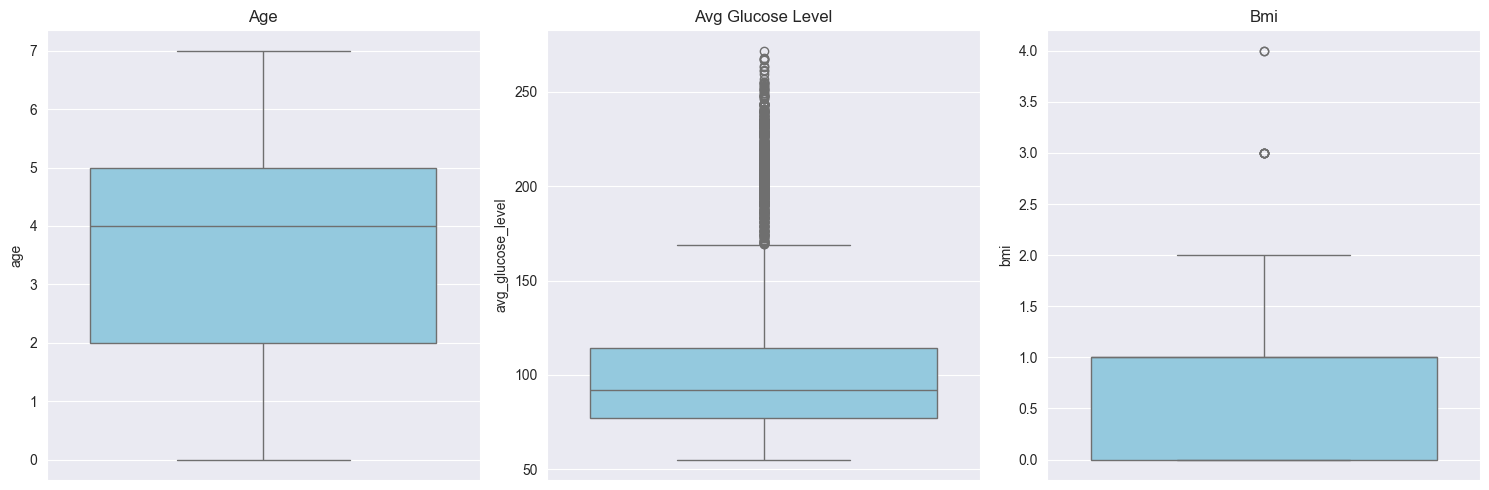

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

file_name = 'data/processed_data.csv'
df = pd.read_csv(file_name)


numerical_cols = ['age', 'avg_glucose_level', 'bmi']
print(f"Detecting outliers in: {numerical_cols}\n")

# IQR Method

def remove_iqr_outliers(df, cols):
    cleaned_df = df.copy()
    for col in cols:
        Q1, Q3 = cleaned_df[col].quantile([0.25, 0.75])
        IQR = Q3 - Q1
        bounds = (Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)
        cleaned_df = cleaned_df[cleaned_df[col].between(*bounds)]
    return cleaned_df

initial_rows = len(df)
df_iqr_cleaned = remove_iqr_outliers(df, numerical_cols)

print("IQR Outlier Removal Summary:")
print(f"  Original rows: {initial_rows}")
print(f"  Cleaned rows:  {len(df_iqr_cleaned)}")
print(f"  Outliers removed: {initial_rows - len(df_iqr_cleaned)}\n")

output_file = 'data/processed_data_outliers_removed.csv'
df_iqr_cleaned.to_csv(output_file, index=False)
print(f"Cleaned dataset saved to: {output_file}")

#Visualization
fig, axes = plt.subplots(1, len(numerical_cols), figsize=(15, 5))
for ax, col in zip(axes, numerical_cols):
    sns.boxplot(y=df[col], ax=ax, color='skyblue')
    ax.set_title(f'{col.replace("_", " ").title()}')
plt.tight_layout()
plt.show()


### Scatter Plots - the data is discrete error

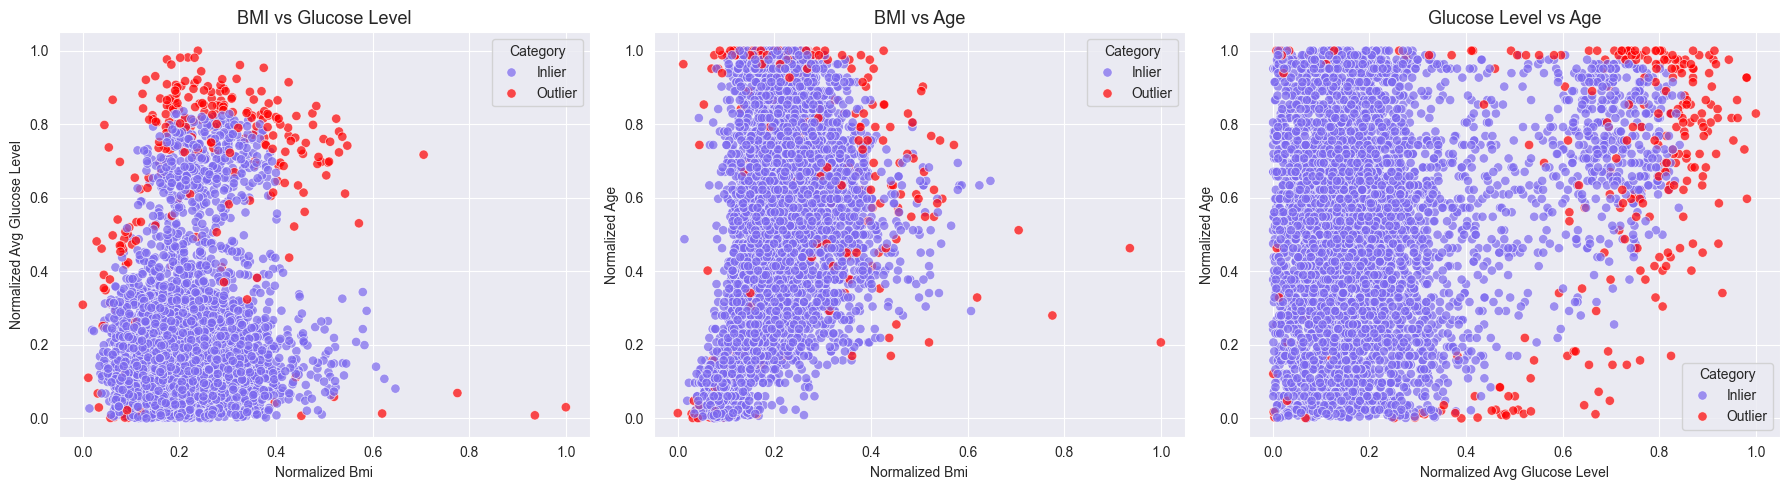

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler

# --- 1. Load Dataset ---
df = pd.read_csv('data/healthcare-dataset-stroke-data.csv')
numerical_cols = ['age', 'avg_glucose_level', 'bmi']

#print("🔹 Starting preprocessing...")
# # --- 2. Data Cleaning ---
# initial_rows = len(df)
# df.drop_duplicates(inplace=True)
# print(f"Duplicates removed: {initial_rows - len(df)}")

# df.replace([np.inf, -np.inf], np.nan, inplace=True)
# rows_before_na = len(df)
# df.dropna(subset=numerical_cols, inplace=True)
# print(f"Rows with missing data removed: {rows_before_na - len(df)}")

# normalize data
scaler = MinMaxScaler()
df_scaled = df.copy()
df_scaled[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Isolation Forest Outlier Detection
model = IsolationForest(random_state=42, contamination=0.05)
df_scaled['is_outlier_if'] = np.where(
    model.fit_predict(df_scaled[numerical_cols]) == -1,
    'Outlier',
    'Inlier'
)

# visualize
pairs = [
    ('bmi', 'avg_glucose_level', 'BMI vs Glucose Level'),
    ('bmi', 'age', 'BMI vs Age'),
    ('avg_glucose_level', 'age', 'Glucose Level vs Age')
]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 row, 3 columns

palette = {'Inlier': '#7B68EE', 'Outlier': 'red'}  # lilac-blue & red

for ax, (x, y, title) in zip(axes, pairs):
    sns.scatterplot(
        x=x, y=y, hue='is_outlier_if', data=df_scaled,
        palette=palette, s=45, alpha=0.7, ax=ax
    )
    ax.set_title(title, fontsize=13)
    ax.set_xlabel(f'Normalized {x.replace("_", " ").title()}')
    ax.set_ylabel(f'Normalized {y.replace("_", " ").title()}')
    ax.legend(title='Category')

plt.tight_layout()
plt.show()


## ML Approach

### Linear Regression

🔹 Linear Regression residual outliers detected: 32


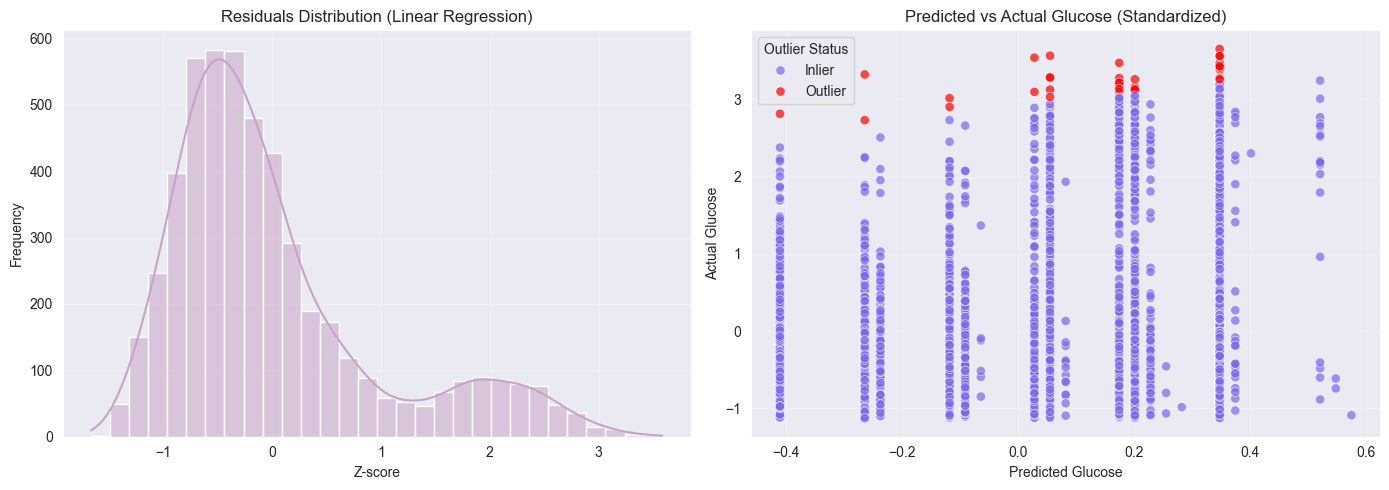

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

#double check no duplicates
df = pd.read_csv('data/processed_data.csv')
numerical_cols = ['age', 'bmi', 'avg_glucose_level']
df = df.drop_duplicates().dropna(subset=numerical_cols)

#normalize
scaler = StandardScaler()
df_std = df.copy()
df_std[[f"{col}_std" for col in numerical_cols]] = scaler.fit_transform(df[numerical_cols])


df_std['age_bin'] = pd.cut(df_std['age_std'], bins=5, labels=False)
df_std['bmi_bin'] = pd.cut(df_std['bmi_std'], bins=5, labels=False)


X = df_std[['age_bin', 'bmi_bin']]
y = df_std['avg_glucose_level_std']

model = LinearRegression().fit(X, y)
pred = model.predict(X)
residuals = y - pred

# Z-score
z_scores = (residuals - residuals.mean()) / residuals.std()
df_std['lin_outlier'] = np.where(np.abs(z_scores) > 3, 'Outlier', 'Inlier')
print(f"🔹 Linear Regression residual outliers detected: {(np.abs(z_scores) > 3).sum()}")


fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# (a) Residual Distribution
sns.histplot(residuals, bins=30, kde=True, color='#C8A2C8', ax=axes[0])
axes[0].set_title("Residuals Distribution (Linear Regression)")
axes[0].set_xlabel("Z-score")
axes[0].set_ylabel("Frequency")
axes[0].grid(alpha=0.3)

# (b) Predicted vs Actual Scatter Plot
sns.scatterplot(
    x=pred, y=y, hue='lin_outlier', data=df_std,
    palette={'Inlier': '#7B68EE', 'Outlier': 'red'},
    s=45, alpha=0.7, ax=axes[1]
)
axes[1].set_title("Predicted vs Actual Glucose (Standardized)")
axes[1].set_xlabel("Predicted Glucose")
axes[1].set_ylabel("Actual Glucose")
axes[1].grid(alpha=0.3)
axes[1].legend(title="Outlier Status")

plt.tight_layout()
plt.show()


### Piecewise (Segmented) Regression

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler


# --- Standardize numeric columns ---
scaler = StandardScaler()
df[[f"{col}_std" for col in num_cols]] = scaler.fit_transform(df[num_cols])

# --- Discretize standardized age & BMI ---
df['age_bin'] = pd.cut(df['age_std'], bins=5, labels=False)
df['bmi_bin'] = pd.cut(df['bmi_std'], bins=5, labels=False)

# --- Hinge function (for piecewise regression) ---
def hinge(x, knot): return np.maximum(0, x - knot)

# --- Prepare segmented regression features ---
age_knot, bmi_knot = df['age_bin'].median(), df['bmi_bin'].median()
X_seg = pd.DataFrame({
    'age_bin': df['age_bin'],
    'bmi_bin': df['bmi_bin'],
    'age_hinge': hinge(df['age_bin'], age_knot),
    'bmi_hinge': hinge(df['bmi_bin'], bmi_knot)
})
y_seg = df['avg_glucose_level_std']

# --- Fit segmented regression ---
model = LinearRegression().fit(X_seg, y_seg)
resid = y_seg - model.predict(X_seg)

# --- Detect outliers using z-score ---
z = (resid - resid.mean()) / resid.std()
df['seg_outlier'] = np.where(np.abs(z) > 3, 'Outlier', 'Inlier')
print(f"Segmented regression residual outliers detected: {(np.abs(z) > 3).sum()}")

# --- Plot: Residual Distribution & Predicted vs Actual ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Residual Distribution
sns.histplot(resid, bins=30, kde=True, color='lightgreen', ax=axes[0])
axes[0].set_title("Residuals Distribution")
axes[0].set_xlabel("Residuals")
axes[0].set_ylabel("Frequency")
axes[0].grid(alpha=0.3)

# Predicted vs Actual
sns.scatterplot(
    x=model.predict(X_seg),
    y=y_seg,
    hue=df['seg_outlier'],
    palette={'Inlier': 'blue', 'Outlier': 'red'},
    s=40, alpha=0.7, ax=axes[1]
)
axes[1].set_title("Predicted vs Actual Glucose (Segmented Regression)")
axes[1].set_xlabel("Predicted Glucose (Standardized)")
axes[1].set_ylabel("Actual Glucose (Standardized)")
axes[1].legend(title="Outlier Status")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


NameError: name 'num_cols' is not defined

### Clustering (DBSCAN)

DBSCAN outliers detected: 8


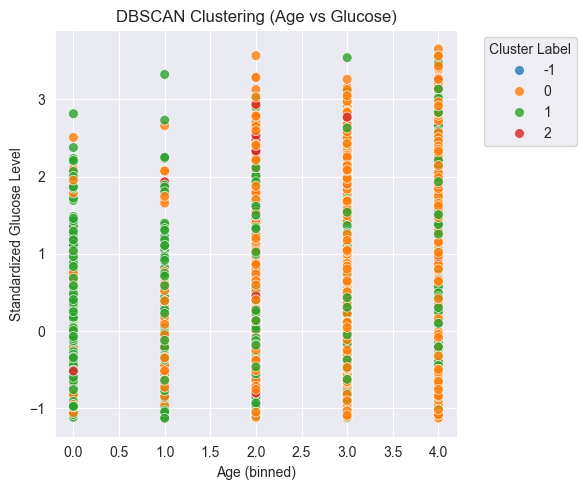

In [74]:
# === Clustering-Based Outlier Detection (DBSCAN) ===
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- Select and scale features ---
features = ['age_bin', 'bmi_bin', 'avg_glucose_level_std']
X_scaled = StandardScaler().fit_transform(df[features])

# --- Apply DBSCAN ---
dbscan = DBSCAN(eps=1.2, min_samples=10)
df['dbscan_label'] = dbscan.fit_predict(X_scaled)

# --- Mark outliers (label = -1) ---
df['db_outlier'] = np.where(df['dbscan_label'] == -1, 'Outlier', 'Inlier')
print(f"DBSCAN outliers detected: {(df['dbscan_label'] == -1).sum()}")

# --- Visualization: Age vs Glucose ---
plt.figure(figsize=(6, 5))
sns.scatterplot(
    data=df,
    x='age_bin', y='avg_glucose_level_std',
    hue='dbscan_label',
    palette='tab10', s=50, alpha=0.8
)
plt.title("DBSCAN Clustering (Age vs Glucose)")
plt.xlabel("Age (binned)")
plt.ylabel("Standardized Glucose Level")
plt.legend(title="Cluster Label", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
